# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_3', 'block14_sepconv1', 'block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7837 - accuracy: 0.7424

947/947 [==============================] - 2480s 3s/step - loss: 0.7837 - accuracy: 0.7424 - val_loss: 0.9092 - val_accuracy: 0.7127
Epoch 2/200
947/947 [==============================] - 2422s 3s/step - loss: 0.6578 - accuracy: 0.7747 - val_loss: 1.1007 - val_accuracy: 0.7143
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.7915

947/947 [==============================] - 2443s 3s/step - loss: 0.6078 - accuracy: 0.7915 - val_loss: 0.6547 - val_accuracy: 0.7749
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.8005

947/947 [==============================] - 2483s 3s/step - loss: 0.5729 - accuracy: 0.8005 - val_loss: 0.6152 - val_accuracy: 0.7873
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.8089

947/947 [==============================] - 2576s 3s/step - loss: 0.5453 - accuracy: 0.8089 - val_loss: 0.5906 - val_accuracy: 0.7922
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8153

947/947 [==============================] - 2555s 3s/step - loss: 0.5218 - accuracy: 0.8153 - val_loss: 0.5707 - val_accuracy: 0.7950
Epoch 7/200
947/947 [==============================] - 2444s 3s/step - loss: 0.4957 - accuracy: 0.8224 - val_loss: 0.5989 - val_accuracy: 0.7883
Epoch 8/200
947/947 [==============================] - 2517s 3s/step - loss: 0.4802 - accuracy: 0.8276 - val_loss: 0.7062 - val_accuracy: 0.7723
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8353

947/947 [==============================] - 2805s 3s/step - loss: 0.4640 - accuracy: 0.8353 - val_loss: 0.5327 - val_accuracy: 0.8060
Epoch 10/200
947/947 [==============================] - 2897s 3s/step - loss: 0.4467 - accuracy: 0.8415 - val_loss: 0.6164 - val_accuracy: 0.7887
Epoch 11/200
947/947 [==============================] - 2883s 3s/step - loss: 0.4247 - accuracy: 0.8465 - val_loss: 0.5350 - val_accuracy: 0.8190
Epoch 12/200
947/947 [==============================] - 2902s 3s/step - loss: 0.4129 - accuracy: 0.8523 - val_loss: 0.5529 - val_accuracy: 0.8139
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8572

947/947 [==============================] - 2905s 3s/step - loss: 0.3980 - accuracy: 0.8572 - val_loss: 0.5302 - val_accuracy: 0.8239
Epoch 14/200
947/947 [==============================] - 2901s 3s/step - loss: 0.3832 - accuracy: 0.8630 - val_loss: 0.5649 - val_accuracy: 0.8152
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8651

947/947 [==============================] - 2844s 3s/step - loss: 0.3694 - accuracy: 0.8651 - val_loss: 0.4978 - val_accuracy: 0.8239
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8723

947/947 [==============================] - 2485s 3s/step - loss: 0.3557 - accuracy: 0.8723 - val_loss: 0.4812 - val_accuracy: 0.8353
Epoch 17/200
947/947 [==============================] - 2422s 3s/step - loss: 0.3375 - accuracy: 0.8792 - val_loss: 0.4869 - val_accuracy: 0.8414
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8787

947/947 [==============================] - 2448s 3s/step - loss: 0.3307 - accuracy: 0.8787 - val_loss: 0.4697 - val_accuracy: 0.8414
Epoch 19/200
947/947 [==============================] - 2422s 3s/step - loss: 0.3142 - accuracy: 0.8876 - val_loss: 0.5372 - val_accuracy: 0.8168
Epoch 20/200
947/947 [==============================] - 2416s 3s/step - loss: 0.3001 - accuracy: 0.8907 - val_loss: 0.4899 - val_accuracy: 0.8386
Epoch 21/200
947/947 [==============================] - 2411s 3s/step - loss: 0.2872 - accuracy: 0.8963 - val_loss: 0.5002 - val_accuracy: 0.8382
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8992

947/947 [==============================] - 2422s 3s/step - loss: 0.2793 - accuracy: 0.8992 - val_loss: 0.4394 - val_accuracy: 0.8522
Epoch 23/200
947/947 [==============================] - 2407s 3s/step - loss: 0.2648 - accuracy: 0.9033 - val_loss: 0.5195 - val_accuracy: 0.8398
Epoch 24/200
947/947 [==============================] - 2393s 3s/step - loss: 0.2554 - accuracy: 0.9063 - val_loss: 0.4445 - val_accuracy: 0.8477
Epoch 25/200
947/947 [==============================] - 2383s 3s/step - loss: 0.2422 - accuracy: 0.9132 - val_loss: 0.5243 - val_accuracy: 0.8344
Epoch 26/200
947/947 [==============================] - 2401s 3s/step - loss: 0.2307 - accuracy: 0.9168 - val_loss: 0.5165 - val_accuracy: 0.8357
Epoch 27/200
947/947 [==============================] - 2384s 3s/step - loss: 0.2278 - accuracy: 0.9165 - val_loss: 0.4864 - val_accuracy: 0.8367
Epoch 28/200
947/947 [==============================] - 2403s 3s/step - loss: 0.2183 - accuracy: 0.9218 - val_loss: 0.5366 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 255s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9753152779520985,
 'basal cell carcinoma': 0.987321196818013,
 'dermatofibroma': 0.9835335676043642,
 'melanoma': 0.9425260172663457,
 'nevus': 0.9716957424475755,
 'pigmented benign keratosis': 0.9912962513156829,
 'seborrheic keratosis': 0.9642728291210149,
 'solar lentigo': 0.9654479882405224,
 'squamous cell carcinoma': 0.9639231379335207,
 'vascular lesion': 0.9824456651540482}

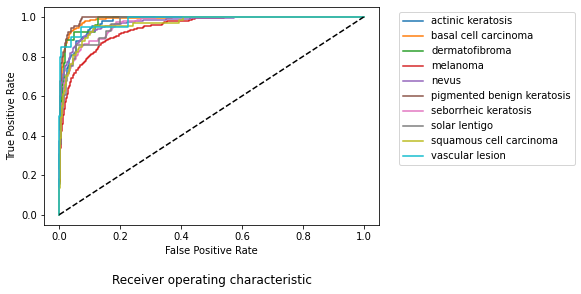

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

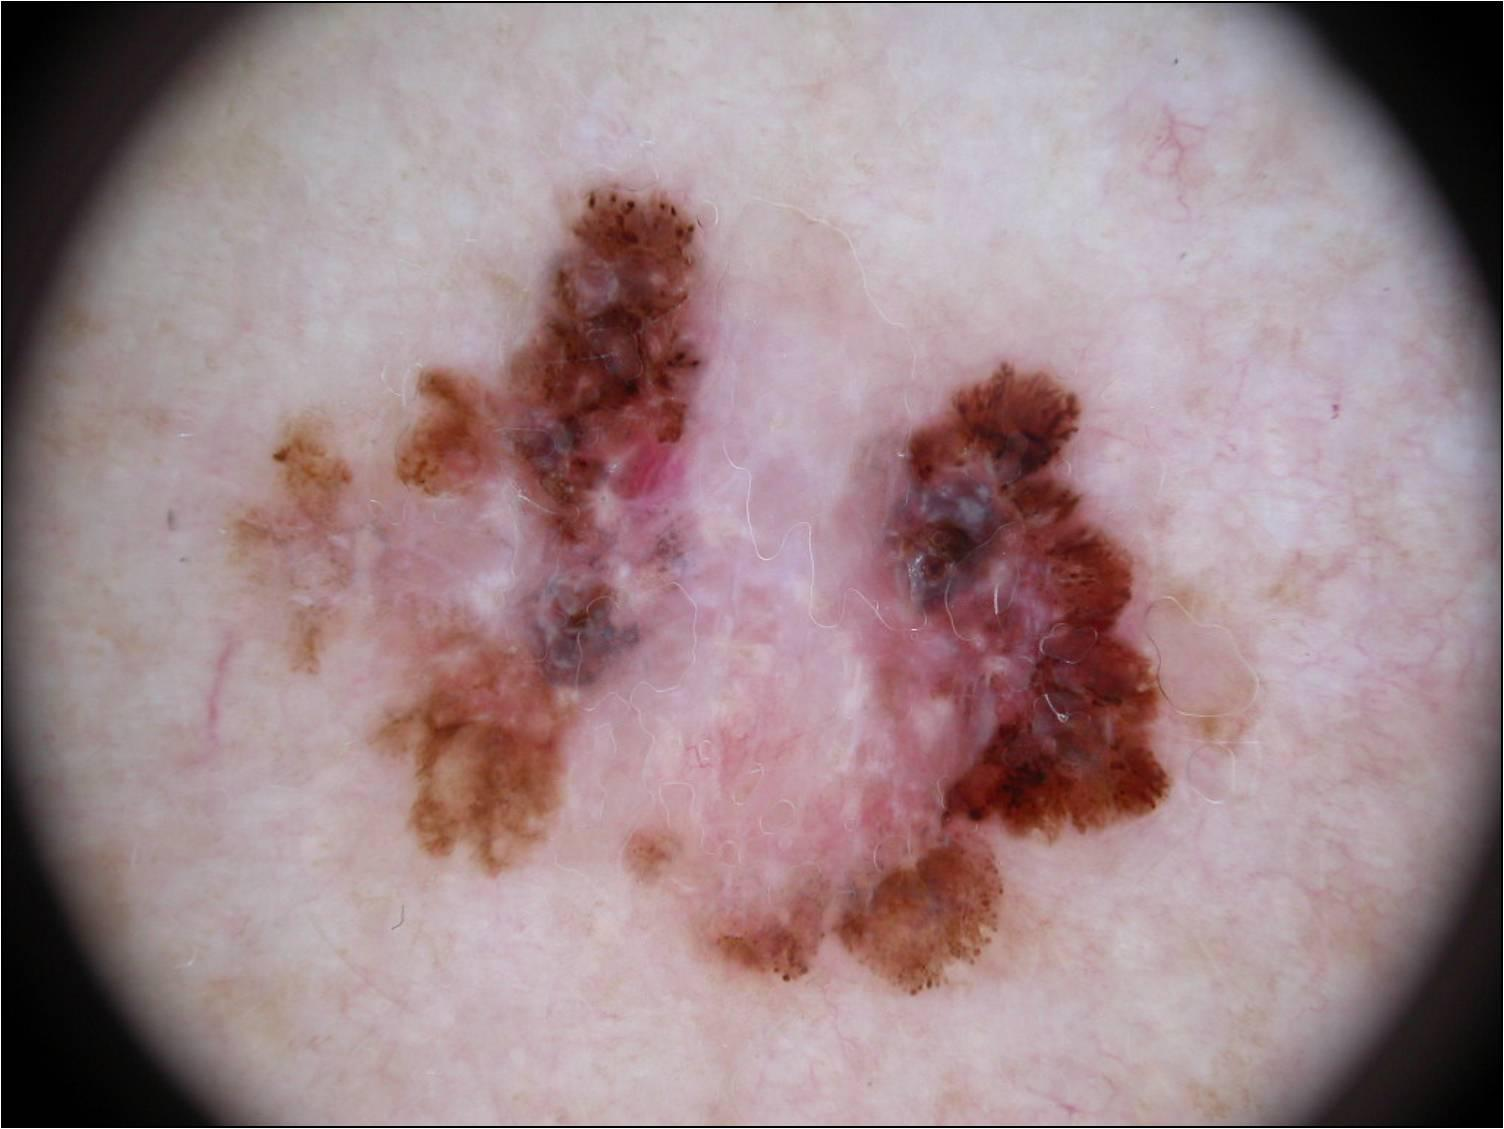

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

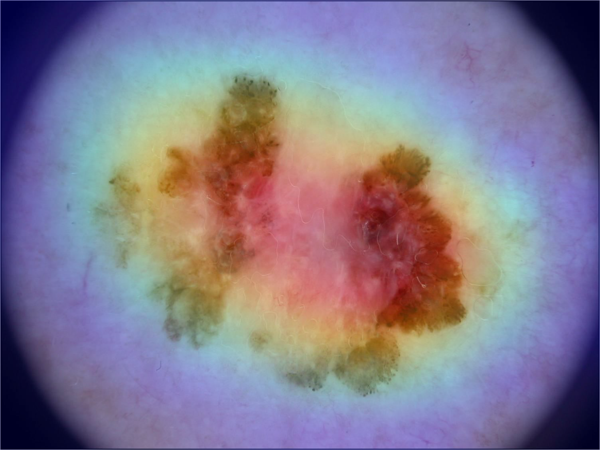

In [23]:
display_gradcam(melanoma_im_path, heatmap)